In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from data import loaddin, loadbird, loadhouse, loadGustavIIAdolf
from featureMatching import FeatureMatching
from scipy.linalg import null_space, rq

In [2]:
img, matrixCalibration = loadGustavIIAdolf()

In [3]:
P1 = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0]
])

P2 = np.array([
    [0.707, -0.707, 0, 1],
    [0.707, 0.707, 0, 0],
    [0, 0, 1, 1]
])



In [4]:
def convert_P_to_F(P1, P2):
    # Compute the null space of P1 to find the epipole
    C = null_space(P1)
    C /= C[-1]  # Normalize the homogeneous coordinate
    # Compute the skew-symmetric matrix of P2 * C
    first = (P2 @ C).reshape(3,)
    skew_first = np.array([
        [0, -first[2], first[1]],
        [first[2], 0, -first[0]],
        [-first[1], first[0], 0]
    ])
    # Compute P2 * pseudo-inverse of P1
    second = P2 @ np.linalg.pinv(P1)
    # Compute the fundamental matrix
    F = skew_first @ second
    return F
F1 = convert_P_to_F(matrixCalibration[0], matrixCalibration[1])
print(F1/F1[2][2])

ValueError: cannot reshape array of size 0 into shape (3,)

In [ ]:
def compute_pseudo_inverse(P):
    """Compute the Moore-Penrose pseudo-inverse of the camera matrix P."""
    return np.linalg.pinv(P)

def compute_epipole(P_prime):
    """Compute the epipole in the second view from the camera matrix P'."""
    # The epipole is the null space of P'
    U, S, Vt = np.linalg.svd(P_prime)
    e_prime = Vt[-1]
    e_prime /= e_prime[-1]  # Normalize to make the last entry 1
    return e_prime

def skew_symmetric_matrix(v):
    """Construct a skew-symmetric matrix from a vector v."""
    return np.array([
        [0, -v[2], v[1]],
        [v[2], 0, -v[0]],
        [-v[1], v[0], 0]
    ])

def compute_fundamental_matrix(P, P_prime):
    """Compute the fundamental matrix F from camera matrices P and P'."""
    P_pseudo_inverse = compute_pseudo_inverse(P)
    e_prime = compute_epipole(P_prime)
    skew_symmetric = skew_symmetric_matrix(e_prime)
    P_prime_P_pseudo_inverse = np.dot(P_prime, P_pseudo_inverse)
    F = np.dot(skew_symmetric, P_prime_P_pseudo_inverse)
    return F


# Compute the fundamental matrix
F2 = compute_fundamental_matrix(matrixCalibration[0].copy(), matrixCalibration[1].copy())
print("Fundamental Matrix F:")
print(F2/F2[2,2])


Fundamental Matrix F:
[[ 3.20061332e-07 -7.62225847e-09 -6.00923694e-03]
 [ 1.80716616e-06 -4.30376499e-08 -3.39300270e-02]
 [ 7.90114617e-03  3.35072377e-02  1.00000000e+00]]


In [ ]:
X = [4,5,6,1]
x  = matrixCalibration[0]@X
xp = matrixCalibration[1]@X

x /= x[-1]
xp /= xp[-1]

print(xp.T@F1/F1[2,2]@x)
print(xp.T@F2/F2[2,2]@x)

1.1368683772161603e-13
-0.3474505381271058


In [ ]:
# center      = []
# rotation    = []
# for i in range(0):
#     print(f"Index:{i}-------------------------------------------------------------------------")
#     ns = null_space(matrixCalibration[i])
#     ns /= ns[3]
#     print("Center of Camera:-------------------------------------------------")
#     print(ns)

#     r, q = rq(matrixCalibration[i][:,0:3])
#     print("Camera Intrinsics:-------------------------------------------------")
#     print(r/r[2,2])
#     print("Rotation of Camera:-------------------------------------------------")
#     print(q)

#     M = r@q
#     print("Pose Camera Matrix Reconstruction:-------------------------------------------------")
#     print(np.hstack((M, M@ns[:3])))
#     print("Main Pose Camera Matrix:-------------------------------------------------")
#     print(matrixCalibration[i])

#     center.append(ns[:3])
#     rotation.append(q)



In [ ]:
def extract_intrinsic_matrix(P):
    M = P[:, 0:3]
    
    M = np.linalg.inv(M)
    
    Q, K = np.linalg.qr(M)
    
    K = np.linalg.inv(K)
    K /= K[2, 2]
    return K

Projection = matrixCalibration.copy()
for i in range(len(matrixCalibration)):
    matrixCalibration[i] = extract_intrinsic_matrix(matrixCalibration[i])
print(matrixCalibration[0])

[[ 3.21732867e+03 -7.86066410e+01  2.89867240e+02]
 [ 0.00000000e+00  2.29242414e+03 -1.07051623e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [7]:
class TwoFrameReconstruction:
    def __init__(self, img1, img2, k1, k2) -> None:
        self.img1   = img1
        self.img2   = img2
        self.k1     = np.array(k1)
        self.k2     = np.array(k2)
        self.pts1   = None
        self.pts2   = None
        self.F      = None
        self.E      = None
        self.P1     = None
        self.P2     = None
        self.X      = None
        self.FM     = FeatureMatching(img1, img2)
        pass

    def run(self):
        self.featuerMatching()
        self.fundamental_matrix()
        self.essential_matrix()
        self.camera_matrix()
        self.triangulate()
        return self.X

    def featuerMatching(self):
        self.pts1, self.pts2 = self.FM.BruteForceMatchingORB()

    def fundamental_matrix(self):
        min_error = np.inf
        for i in range(100):
            error = 0
            f, mask = cv.findFundamentalMat(self.pts1, self.pts2, cv.FM_RANSAC)

            p1 = self.pts1[mask.ravel()==1].reshape(-1, 2)
            p2 = self.pts2[mask.ravel()==1].reshape(-1, 2)
            hom_point1 = np.hstack((p1, np.ones(shape=(p1.shape[0],1))))
            hom_point2 = np.hstack((p2, np.ones(shape=(p2.shape[0],1))))
            for i in range(p1.shape[0]):
                error += hom_point2[i].T @ f @ hom_point1[i]
            if error < min_error:
                min_error = error
                self.F = f

 
    def essential_matrix(self):
        self.E = self.k2.T @ self.F @ self.k1

    def camera_matrix(self):
        U, S, Vt = np.linalg.svd(self.E)
        
        W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
        R = U @ W @ Vt  
        t = U[:,2]

        self.P1 = self.k1 @ np.hstack((np.eye(3), np.zeros((3, 1))))
        self.P2 = self.k2 @ np.hstack((R, t.reshape(-1, 1)))

        # print('-----------------------------------------')
        # print(self.P1)
        # print('-----------------------------------------')
        # print(self.P2)
        # print('-----------------------------------------')
        # print(Projection[0])
        # print('-----------------------------------------')
        # print(Projection[1])
        # print('-----------------------------------------')

    def triangulate(self):
        X = []
        try:
            self.pts1 = self.pts1.reshape(-1, 2)
            self.pts2 = self.pts2.reshape(-1, 2)
        except: ...
        
        n = self.pts1.shape[0]
        for i in range(n):
            A = []
            A.append(self.pts1[i][1]*self.P1[2,:] - self.P1[1,:])
            A.append(self.P1[0,:] - self.pts2[i][0]*self.P1[2,:])
            A.append(self.pts2[i][1]*self.P2[2,:] - self.P2[1,:])
            A.append(self.P2[0,:] - self.pts2[i][1]*self.P2[2,:])

            A = np.array(A)
            U, S, Vt = np.linalg.svd(A)
            X.append(Vt.T[:, -1])
            X[-1] /= X[-1][3]

        X = np.array(X)
        self.X = X

        # hom_points = cv.triangulatePoints(self.P1, self.P2, self.pts1.T, self.pts2.T)
        # hom_points /= hom_points[3]
        # self.X = hom_points[:3].T

    def remove_outliers(self, eps=0.5, min_samples=5):
        points = self.X
        
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(points)
        
        labels = db.labels_
        
        inliers = labels != -1
        
        self.X = self.X[inliers]

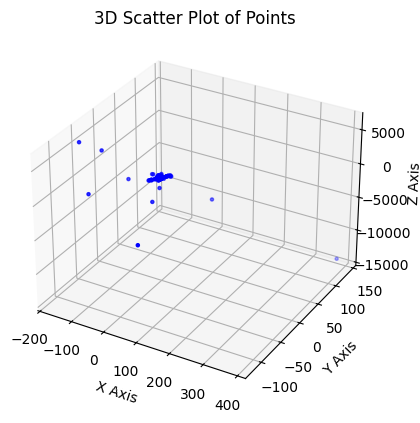

In [8]:
X = None
for i in range(5):
    img1 = img[i]
    img2 = img[i+1]

    cal1 = matrixCalibration[i]
    cal2 = matrixCalibration[i+1]

    tfr = TwoFrameReconstruction(img1, img2, cal1, cal2)
    tfr.run()
    # tfr.remove_outliers()
    if X is None:
        X = tfr.X
    else:
        X = np.vstack((X, tfr.X))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = X[:, 0]
y = X[:, 1]
z = X[:, 2]

ax.scatter(x, y, z, c='b', marker='.')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

ax.set_title('3D Scatter Plot of Points')

plt.show()

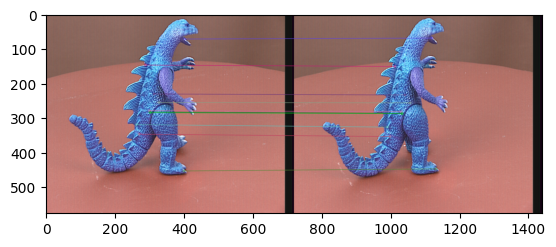

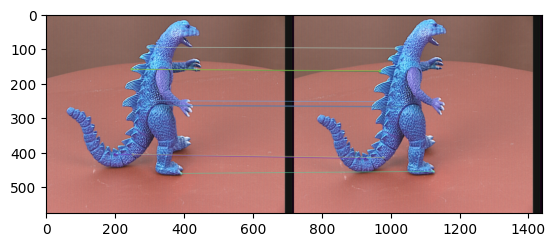

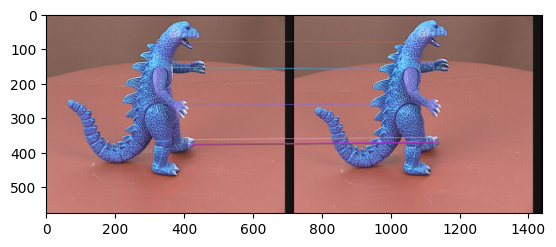

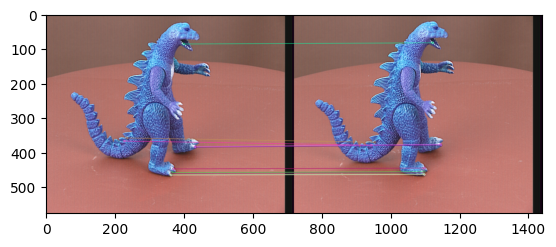

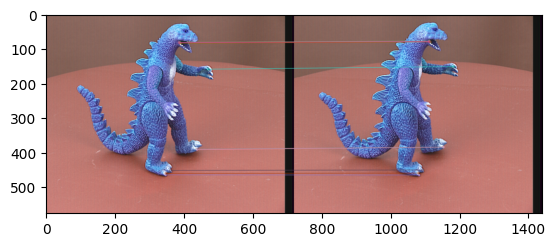

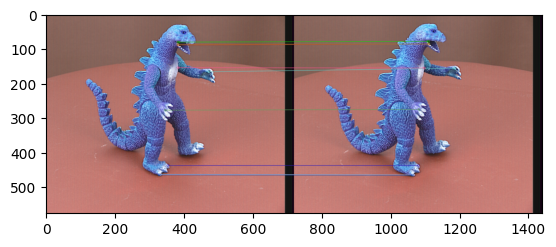

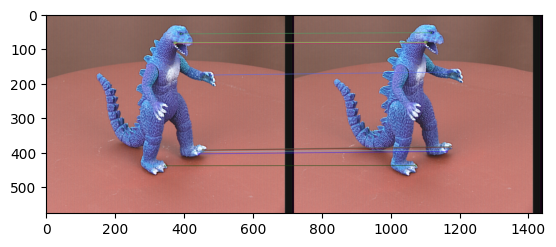

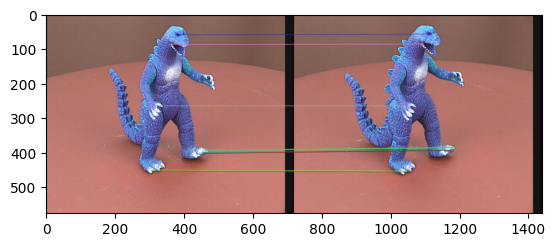

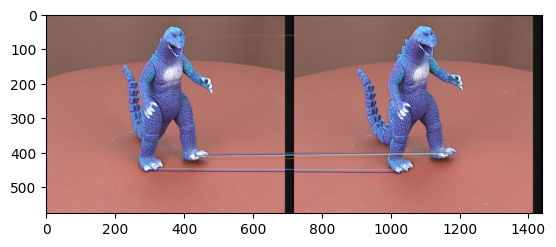

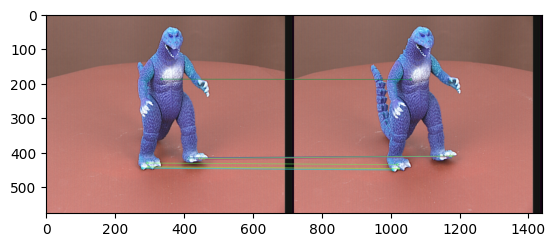

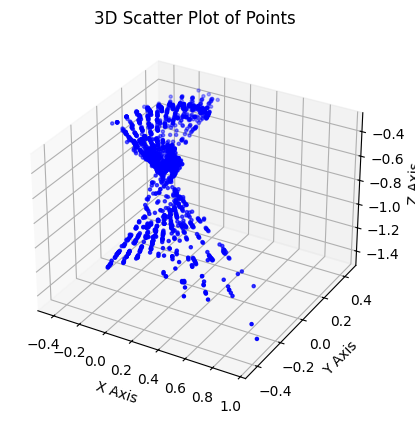

In [ ]:
X = None
for i in range(10):
    img1 = img[i]
    img2 = img[i+1]

    cal1 = Projection[i]
    cal2 = Projection[i+1]

    tfr = TwoFrameReconstruction(img1, img2, None, None)
    tfr.featuerMatching()
    tfr.P1 = cal1
    tfr.P2 = cal2
    tfr.triangulate()
    tfr.remove_outliers()
    if X is None:
        X = tfr.X
    else:
        X = np.vstack((X, tfr.X))


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = X[:, 0]
y = X[:, 1]
z = X[:, 2]

ax.scatter(x, y, z, c='b', marker='.')

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

ax.set_title('3D Scatter Plot of Points')

plt.show()
